## Advanced Lane Finding Notebook ##
This project calibrates images from a vehicles central camera for use in detecting lanes.

### Imports and Constants ###

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import operator
import random
%matplotlib inline

M_PER_PIXEL_y = 30/720 # meters per pixel in y dimension
M_PER_PIXEL_x = 3.7/700 # meters per pixel in x dimension
PIXEL_PER_M_y = 720/30
PIXEL_PER_M_x = 700/3.7


### Display Functions ###

In [2]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=20) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=20)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotStacked(img1, img2, combined, title1, title2, 
                cmap1=None, cmap2='gray'):
    # Stack each channel to view contributions
    stacked = np.dstack((np.zeros_like(img1), img1, img2))
    plotMany(1, 2, [stacked,combined], [title1,title2], [cmap1,cmap2])
    return

def plotWithVerticles(img, offset, title, cmap=None):
    img_size = (img.shape[1], img.shape[0])
    plt.imshow(img, cmap=cmap)
    plt.plot((offset, offset), (0, img_size[1]-offset), 'r-')
    plt.plot((img_size[0]-offset, img_size[0]-offset),
             (0, img_size[1]-offset), 'r-')
    plt.title(title)
    plt.show
    return

### Testing Images ###
Load the images used to prove out the lane finding pipeline

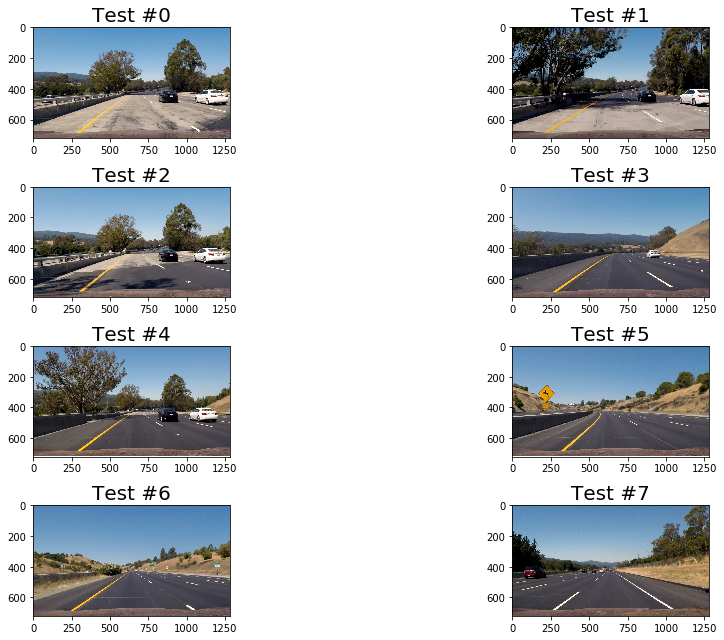

In [3]:
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testImages = testImages+getTestingImages('test_images/straight_lines*.jpg')
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)
    
plotMany(4, 2, testImages, testTitles, testCmap)

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [4]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
        iRGB = cv2.drawChessboardCorners(iRGB, (nx,ny), corners, ret)
    return iRGB

_Testing/Plotting Cell:_

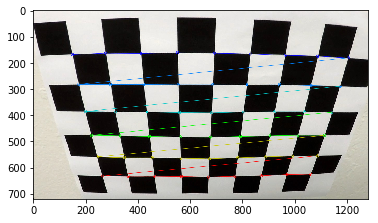

In [5]:
iRGB = findChessboardPoints('camera_cal/calibration2.jpg')
plt.imshow(iRGB)

Process all the provided calibration images and run the calibration.

In [6]:
images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

ret, cameraMtx, distCoeffs, rotVecs, transVecs = cv2.calibrateCamera(
    worldPoints, imagePoints, iRGB.shape[0:2], None, None)

Calibration points found in 18 of 20 images


### Lane Finding Pipeline ###
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation

#### Distortion Correction ####
_Functions for undistortion:_

In [7]:
def undistortImage(img):
    # Undistort the image by refining the camera matrix,
    # running the function, then cropping to the region of interest
    h,w = img.shape[:2]
    newMtx, roi = cv2.getOptimalNewCameraMatrix(cameraMtx, distCoeffs,
                                                (w,h), 1, (w,h))
    undist = cv2.undistort(img, cameraMtx, distCoeffs, None, newMtx)
    x,y,w,h = roi
    return undist[y:y+h, x:x+w]

_Testing/Plotting Cell:_

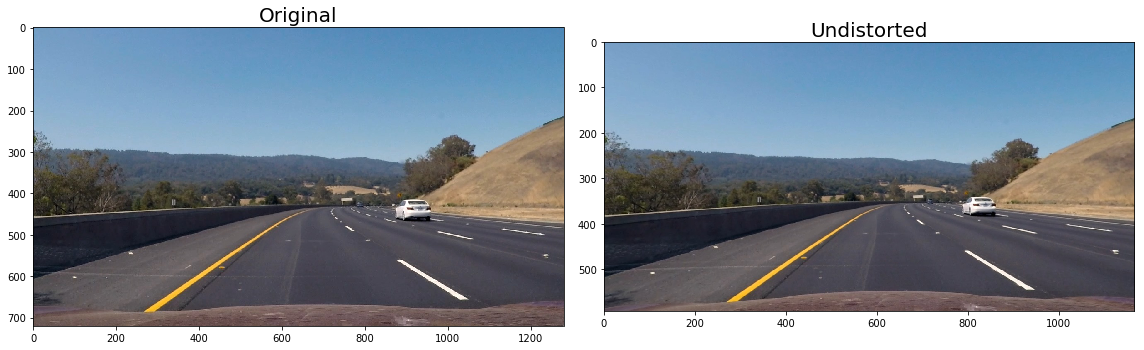

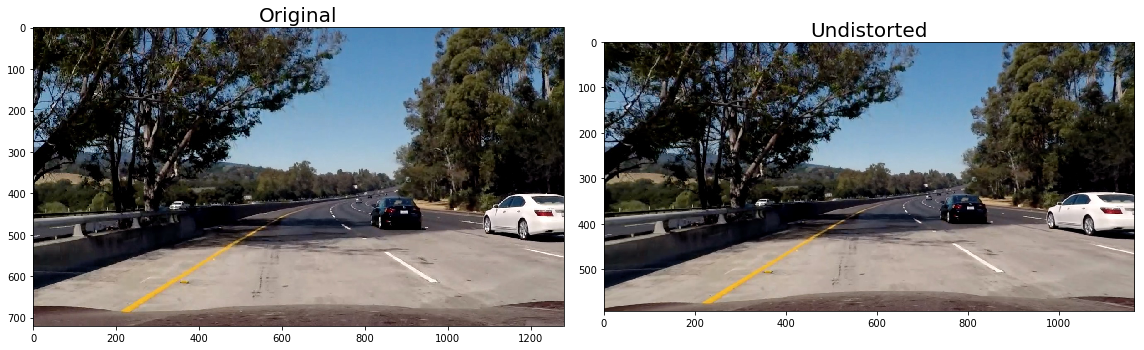

In [8]:
testUndistorteds = []
for img in testImages:
    testUndistorteds.append(undistortImage(img))

samples = random.sample(testImages, 2)
plotTwo(samples[0], undistortImage(samples[0]),
        'Original', 'Undistorted')
plotTwo(samples[1], undistortImage(samples[1]),
        'Original', 'Undistorted')

#### Binary Image Threshold Creation ####
_Functions to create filtered binary images:_  

In [12]:
# ThresholdTesting.ipynb used to determine the following:
SobelKSize = 9
SobelThresh = (50,255)
SobelThreshDir = (0.5, 1.2)
SaturationThresh = (170,255)

def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient, sobel_kernel, thresh):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel, thresh):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel, thresh):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyThresholdSaturation(img, thresh):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyAllThresholds(img):
    # Apply all possible thresholds
    gradx = applyThresholdSobelAbs(img, 'x', SobelKSize, SobelThresh)
    grady = applyThresholdSobelAbs(img, 'y', SobelKSize, SobelThresh)
    magB = applyThresholdSobelMag(img, SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    satB = applyThresholdSaturation(img, SaturationThresh)
    return gradx, grady, magB, dirB, satB   

def combineThresholds(img):
    # Combine thresholds for pipeline use
    magB = applyThresholdSobelMag(img, SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    magDirB = np.zeros_like(dirB)
    magDirB[((magB == 1) & (dirB == 1))] = 1
    
    satB = applyThresholdSaturation(img, SaturationThresh)
    combined = np.zeros_like(satB)
    combined[(satB == 1) | (magDirB == 1)] = 1 
    return magDirB, satB, combined 

_Testing/Plotting Cells:_

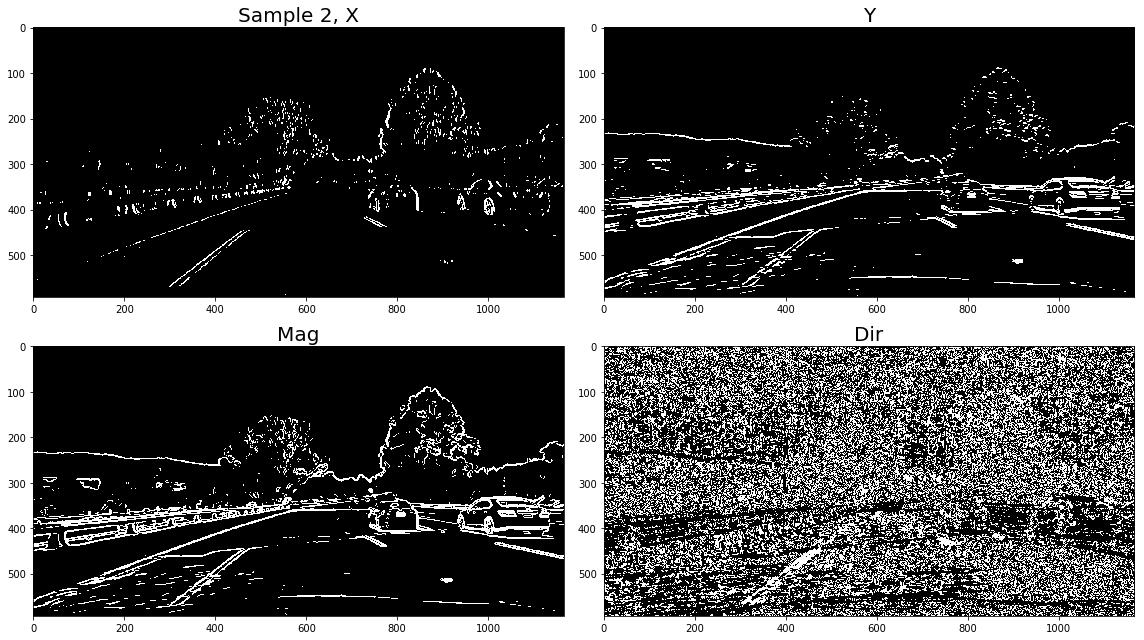

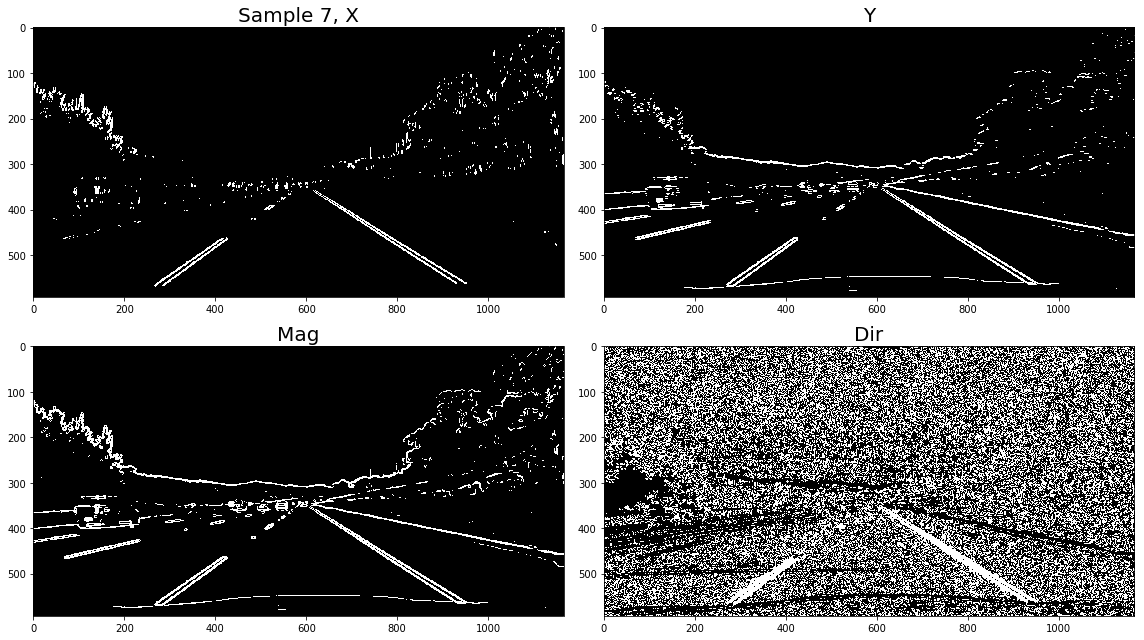

In [10]:
samples = random.sample(range(0,len(testUndistorteds)), 2)
grayMaps = ['gray','gray','gray','gray']

for idx, img in enumerate(testUndistorteds):
    # Run all the threshold calculations
    gradx, grady, magB, dirB, satB = applyAllThresholds(img)
    
    if idx in samples:
        plotMany(2, 2, [gradx,grady,magB,dirB],
                ["Sample {}, X".format(idx),'Y','Mag','Dir'],
                 grayMaps)

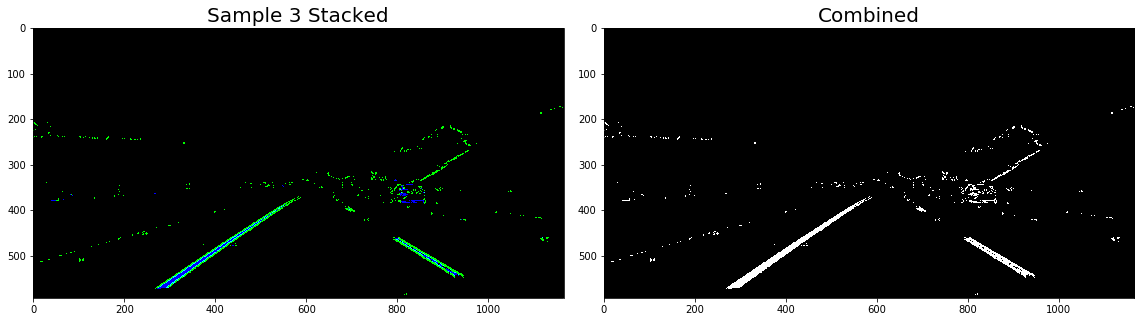

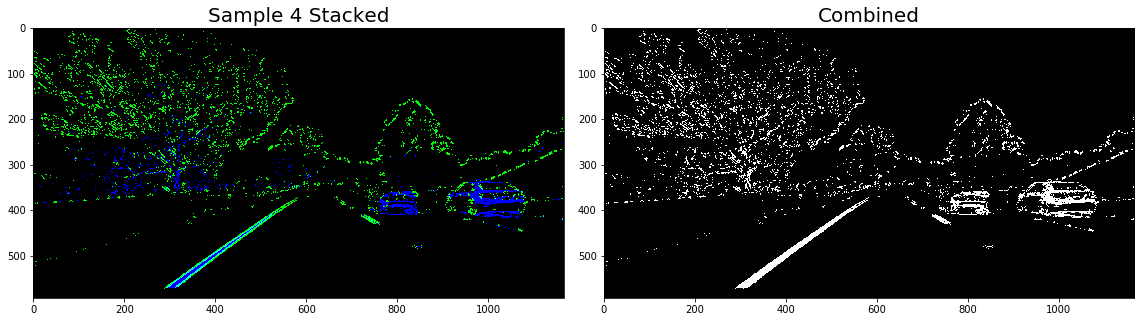

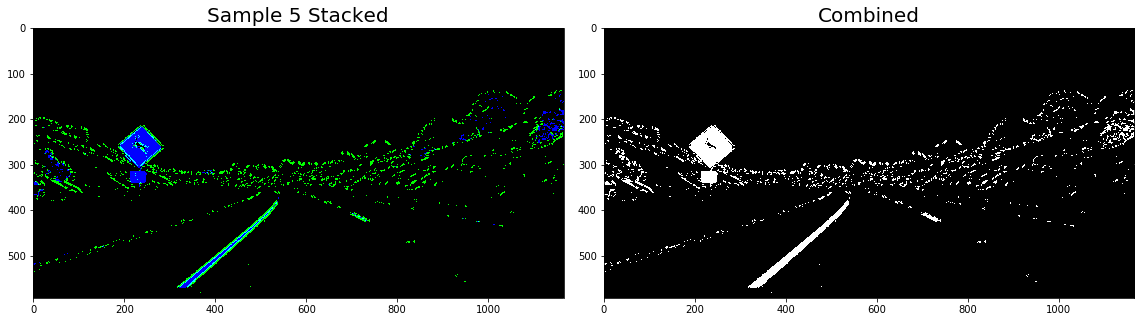

In [13]:
testCombined = []
samples = random.sample(range(0,len(testUndistorteds)), 3)

for idx, img in enumerate(testUndistorteds):
    # Create the combined threshold
    magDirB, satB, combined = combineThresholds(img)
    testCombined.append(combined)
    
    if idx in samples:
        plotStacked(magDirB, satB, combined, 
                    "Sample {} Stacked".format(idx), "Combined")

#### Perspective Transformation ####
_Functions to transform the perspective of the image:_ 

In [77]:
birdsEyeOffset = 75

def warpToBirdsEye(img):
    # Perform a perspective transform for the region of interest
    # using the values calculated above
    left_top = (539, 380)
    left_bottom = (258, 560)
    right_top = (653, 380)
    right_bottom = (962, 560)    
    birdsEyeSrc = np.float32([left_top, right_top, 
                              right_bottom, left_bottom])
    img_size = (img.shape[1], img.shape[0]) 
    birdsEyeDst = np.float32([[birdsEyeOffset, birdsEyeOffset], #L top
                 [img_size[0]-birdsEyeOffset, birdsEyeOffset], #R top
                 [img_size[0]-birdsEyeOffset, 
                  img_size[1]-birdsEyeOffset], #R bottom 
                 [birdsEyeOffset, img_size[1]-birdsEyeOffset] #L bottom
                 ])  
    M = cv2.getPerspectiveTransform(birdsEyeSrc, birdsEyeDst)
    return cv2.warpPerspective(img, M, img_size)

_Testing/Plotting Cells:_

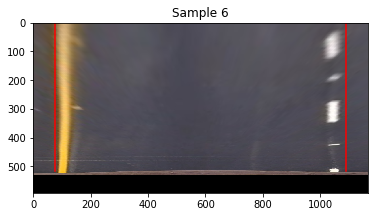

In [78]:
iStraight = warpToBirdsEye(testUndistorteds[6])
plotWithVerticles(iStraight, birdsEyeOffset, 'Sample 6')

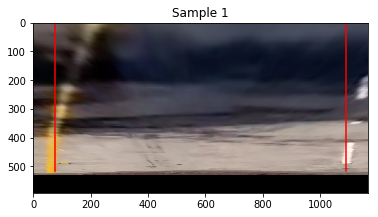

In [79]:
iCurve = warpToBirdsEye(testUndistorteds[1])
plotWithVerticles(iCurve, birdsEyeOffset, 'Sample 1')

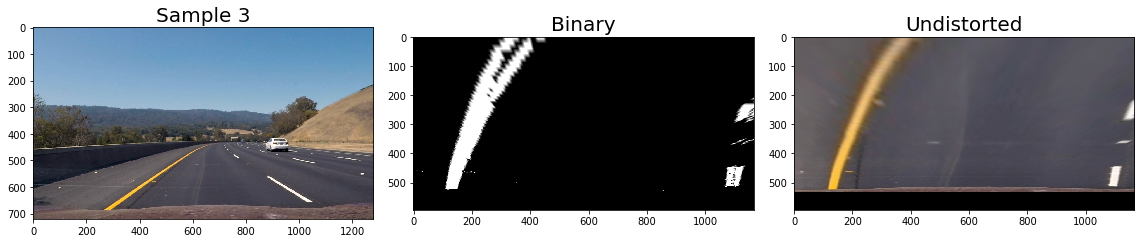

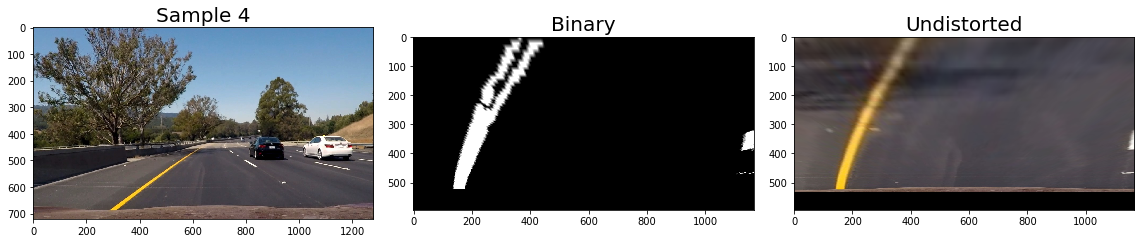

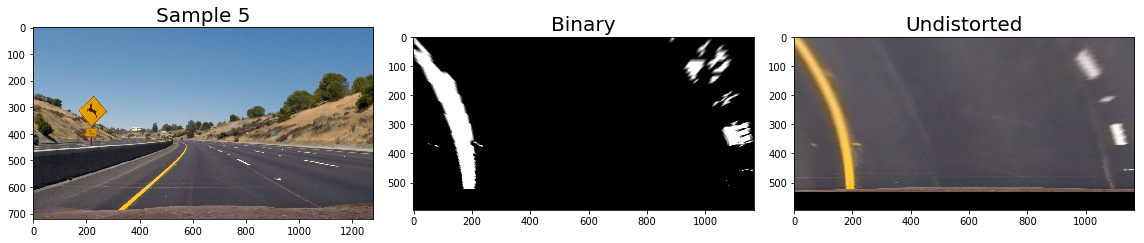

In [80]:
testBirdsEye = []

for idx, img in enumerate(testCombined):
    # Perform the perspective
    warped = warpToBirdsEye(img)
    testBirdsEye.append(warped)
    
    if idx in samples:
        cwarped = warpToBirdsEye(testUndistorteds[idx]) 
        plotMany(1, 3, [testImages[idx], warped, cwarped], 
                 ["Sample {}".format(idx), "Binary", "Undistorted"],
                 [None, 'gray', None])

#### Lane Line Identification ####
_Functions to find the lane lines within the images:_ 

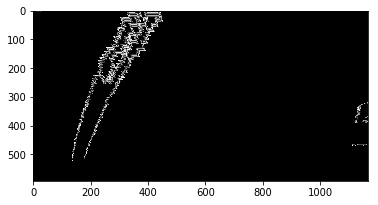

In [89]:
iBirdsEye = testBirdsEye[4]
imageLowerhalf = int(iBirdsEye.shape[0]/2)
hist = np.sum(iBirdsEye[imageLowerhalf:,:], axis=0)

out_img = np.dstack((iBirdsEye, iBirdsEye, iBirdsEye))*255
plt.imshow(out_img)


In [90]:
binary_warped = testBirdsEye[4]

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

_Testing/Plotting Cells:_

(720, 0)

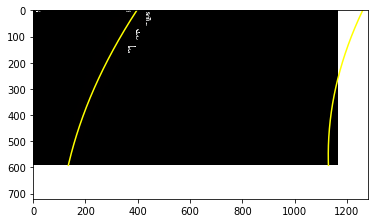

In [92]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

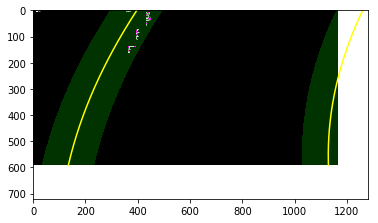

In [93]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Curvature and Location Estimation ####

1472.09864805 1760.65093077
483.031409747 m 578.235957758 m


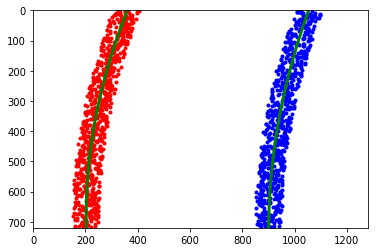

In [95]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

_Testing/Plotting Cells:_